In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [39]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent','Mozilla/5.0')]
urllib.request.install_opener(opener)

In [40]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA NOT AVAILABLE.TRAINING on CPU')
else:
    print('CUDA AVAILABLE.TRAINING ON GPU')


CUDA NOT AVAILABLE.TRAINING on CPU


# Loading Dataset

In [41]:
num_workers = 0
batch_size = 20
valid_size = 0.2

In [42]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [43]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [54]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler = train_sampler,num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler= train_sampler,num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers = num_workers
)

In [46]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Visualize Batch of Training Data

In [47]:
def imshow(img):
    img = img/2+0.5
    plt.imshow(np.transpose(img, (1,2,0)))

In [48]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(20, 3, 32, 32)

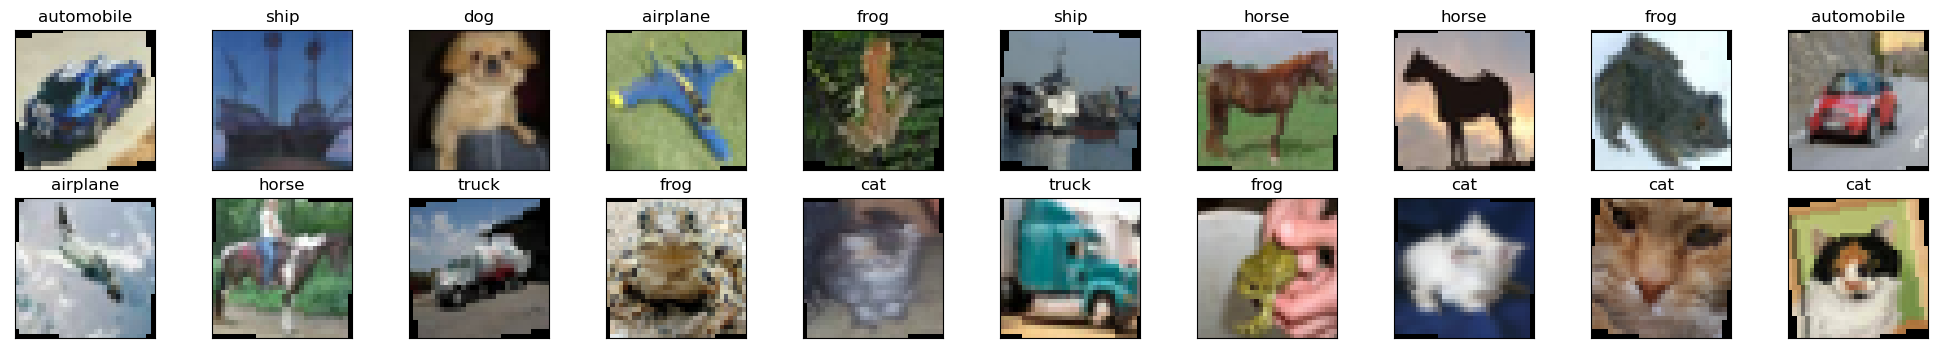

In [21]:
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

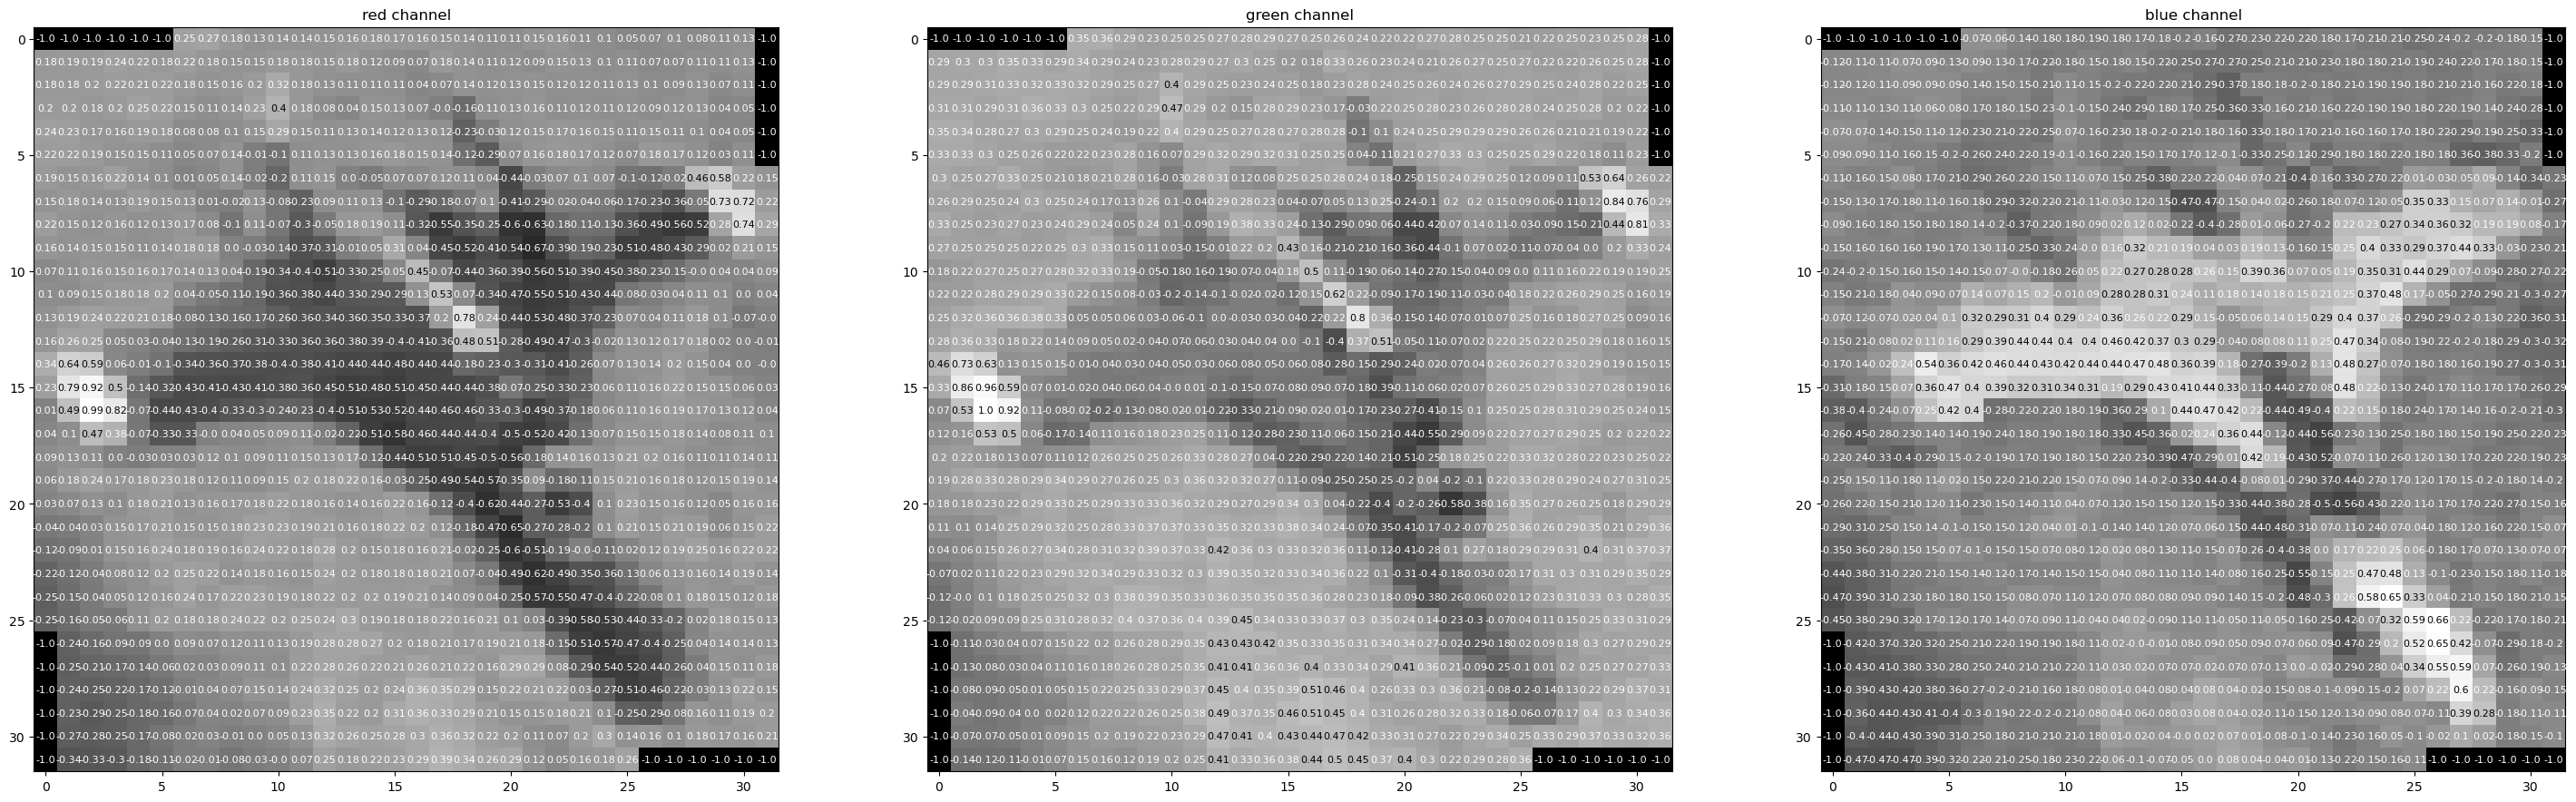

In [25]:
rgb_img = np.squeeze(images[3])
channels = ['red channel','green channel', 'blue channel']

fig = plt.figure(figsize=(36,36))
#for three channels shape[0]
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1,3, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y]!=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')
            

# Defining the CNN Architecture

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3, padding=1)
#         ((n+2p-f)/s + 1) ==> 32*32
        self.pool1 = nn.MaxPool2d(2,2)
#         32 ==> 16
        self.fc_drop1 = nn.Dropout(p=0.2)
    
        self.conv2 = nn.Conv2d(in_channels=16,out_channels = 32, kernel_size=4, padding=1 )
#         (16+2*1-4)/1 +1 ==> 15
        self.pool2 = nn.MaxPool2d(2,2)
#         15==>7
        self.fc_drop2 = nn.Dropout(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels = 64, kernel_size=4, padding=1)
#         (7+2-4)/1 + 1 ==> 6
        self.pool3 = nn.MaxPool2d(2,2)
#         6==>3
#         self.fc_drop3 = nn.Dropout(p=0.2)
        
        self.fc4 = nn.Linear(64*3*3, 10)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.fc_drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.fc_drop2(x)
        x = self.pool2(F.relu(self.conv3(x)))
#         x = self.fc_drop3(x)
        
    #flattern
        x = x.view(x.size(0),-1)
        x = self.fc4(x)
        
        return x
        
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=576, out_features=10, bias=True)
)


In [28]:
if train_on_gpu:
    model.cuda()

# Loss Function and Optimizer

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Network

In [35]:
n_epochs = 30
valid_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
    
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    print('Epoch: {} \t TRaining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Sacing model...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(),'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	 TRaining Loss: 0.840301 	Validation Loss: 0.742675
Validation loss decreased (inf --> 0.742675). Sacing model...
Epoch: 2 	 TRaining Loss: 0.833314 	Validation Loss: 0.741562
Validation loss decreased (0.742675 --> 0.741562). Sacing model...
Epoch: 3 	 TRaining Loss: 0.824533 	Validation Loss: 0.722852
Validation loss decreased (0.741562 --> 0.722852). Sacing model...
Epoch: 4 	 TRaining Loss: 0.816480 	Validation Loss: 0.711407
Validation loss decreased (0.722852 --> 0.711407). Sacing model...
Epoch: 5 	 TRaining Loss: 0.814603 	Validation Loss: 0.707120
Validation loss decreased (0.711407 --> 0.707120). Sacing model...
Epoch: 6 	 TRaining Loss: 0.802183 	Validation Loss: 0.700447
Validation loss decreased (0.707120 --> 0.700447). Sacing model...
Epoch: 7 	 TRaining Loss: 0.799881 	Validation Loss: 0.691346
Validation loss decreased (0.700447 --> 0.691346). Sacing model...
Epoch: 8 	 TRaining Loss: 0.789869 	Validation Loss: 0.696283
Epoch: 9 	 TRaining Loss: 0.789267 	Vali

In [36]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

# Testing the Trained Network

In [55]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.680527

Test Accuracy of airplane: 77% (779/1000)
Test Accuracy of automobile: 87% (876/1000)
Test Accuracy of  bird: 62% (628/1000)
Test Accuracy of   cat: 56% (562/1000)
Test Accuracy of  deer: 81% (815/1000)
Test Accuracy of   dog: 65% (650/1000)
Test Accuracy of  frog: 83% (833/1000)
Test Accuracy of horse: 77% (776/1000)
Test Accuracy of  ship: 89% (897/1000)
Test Accuracy of truck: 81% (819/1000)

Test Accuracy (Overall): 76% (7635/10000)


# Visualizing the Sample Test Results

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]


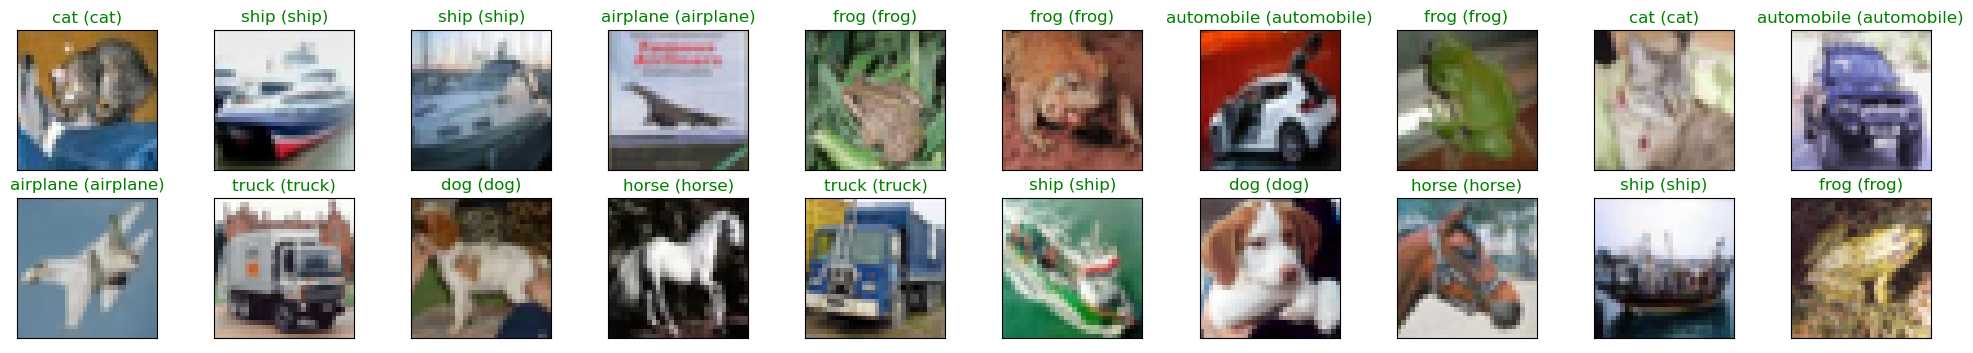

In [60]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
print(preds_tensor)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
print(preds)

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))